<a href="https://colab.research.google.com/github/rykah14/test2/blob/main/test_for_method2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

今回の研究はデータの組み合わせによる比較をメインに実験をした。

データを準備し分類に必要なものだけ洗濯をした箇所最も重要と考える。

そのためBERTの内部のパラメータの調整、エポック数の調整などは行なっておらず、Hugging Face の推奨する値、やり方で行なった。

# 1.事前準備

1.  redditデータセットをGoogleドライブにアップロードする
1.   ColaboratoryファイルをGoogleドライブに接続する(左のサイドバーからファイルアイコンを選択し、Googleドライブと接続するアイコンを押す)
2.   このノートブックに Google ドライブのファイルへのアクセスを許可しますか？というポップアップが出るので許可を選択する

Googleドライブにアップロードされたcsvファイルを読み込む際には、ColaboratoryとGoogleドライブを接続する必要がある

※csvファイルの内容をColaboratory上で書き換えることは行わなかった





# 2.環境構築

tensorflow　をインポートする　

In [48]:
import tensorflow as tf 

GPU環境を構築する

In [49]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


transformersのインストールを行う

この作業をすることでHugging Face社の提供するBERTのツールが使えるようになる

(https://huggingface.co/transformers/v2.2.0/index.html)

BERT以外の自然言語処理のパッケージや画像処理のモデルもモデルもtransformers内に存在する

In [50]:
!pip install transformers　

# 3.データの準備

事前準備でGoogleドライブに格納したredditデータセットをColaboratory上に入力する。

ここでGoogleドライブとColaboratoryファイルが接続されていないとエラーが発生する。

文章数の出力、データの中身の一例の出力は任意であるが、これらを行うことによってデータの中身の概要を知ることができる。

今回のredditデータセットであれば、文章データを表すものはbodyに格納されている、カテゴリー名を表すものはsubredditであると分かる。

In [51]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/reddit.csv")

print('Number of sentences: {:,}\n'.format(df.shape[0]))


df.sample(5)

Number of sentences: 1,000,000



,subreddit,body,controversiality,score
987231,apexlegends,How ironic that you're being indignant on the ...,0,0
79954,ChapoTrapHouse,I started work in 99 when the boomers we're st...,0,2
567130,Market76,Any combination of the following:\n\nAAE Pump ...,0,1
500891,worldnews,Compare pharma's marketing budget to it's R&am...,0,1
55399,worldnews,Wasn't it an illegitimate election?,0,2


redditデータセットの個々のカテゴリー(subreddit)に何個文章データが格納されているのかを知る。

csvファイルの形式に応じて'subreddit' ,'body'を書き換える

In [52]:
print("subreddit多いもの順50")
count_df = df[['subreddit','body']].groupby('subreddit').aggregate({'body':'count'}).reset_index().sort_values('subreddit',ascending=True)
print(count_df.head(50))

subreddit多いもの順50
              subreddit   body
0         AmItheAsshole  25000
1              Animemes  25000
2             AskReddit  25000
3        ChapoTrapHouse  25000
4            FortNiteBR  25000
5              Market76  25000
6          MortalKombat  25000
7                Pikabu  25000
8               RoastMe  25000
9        Showerthoughts  25000
10        SquaredCircle  25000
11           The_Donald  25000
12          apexlegends  25000
13               asoiaf  25000
14                  aww  25000
15            dankmemes  25000
16             freefolk  25000
17                funny  25000
18        gameofthrones  25000
19               gaming  25000
20             gonewild  25000
21               hockey  25000
22      leagueoflegends  25000
23        marvelstudios  25000
24                memes  25000
25               movies  25000
26                  nba  25000
27                 news  25000
28                  nfl  25000
29                 pics  25000
30             politic

分類に使う文章データのカテゴリーと量を決める。

今回は2値分類なので2種類(df_0. df_1)用意した。

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込

# データの抽出
df_0 = df.loc[df['subreddit'].isin(['news']), ['subreddit', 'body']]
#どのカテゴリーを使うかを決めて、抽出したい情報(今回はカテゴリーを表すsubredditと文章を表すbody)を選ぶ
df_0=df_0.replace('news',0)
#以降の学習、検証ではint型のラベル名しかつけられないため、カテゴリーはint型の数値に置き換える
split_dataset_0,discard_0=train_test_split(df_0, train_size=(5000/25000)) 
#必要な数だけ選択するために、train_test_splitを使ってsplit_dataset_0に分類に使う数のみ格納した
print("使えるデータセット")
print(split_dataset_0)
#分類に必要な数だけデータが揃っているか、カテゴリーを示すものがint型の数値になっているのかの2点を確認するためにsplit_dataset_0の中身の一部を出力する

#もう1種類も同じように選択と抽出を行う
df_1 = df.loc[df['subreddit'].isin(['worldnews']), ['subreddit', 'body']]
df_1=df_1.replace('worldnews',1)
split_dataset_1 ,discard_1= train_test_split(df_1, train_size=(5000/25000))
print("使えるデータセット")
print(split_dataset_1)

#以降分類数を増やす際には上記の内容をコピー＆ペーストし、必要な箇所のみを書き換える

list=[]
#分類に使う全てのデータはリストで管理する
list.append(split_dataset_0)
#リストに分類で使うデータを追加する
list.append(split_dataset_1)

df = pd.concat(list, sort=False)
#listの中にデータが格納されているかの確認を行う
#出力結果から、カテゴリーを表す箇所がint型のデータになっているか、分類に必要な数が格納されているかを確認する
print(df)

使えるデータセット
        subreddit                                               body
697849          0                             They hate the economy?
349138          0  It's not that common, it's pretty rare, and th...
453339          0  &gt; Where did I say that only one people can ...
27502           0  Both are obviously also much less effective th...
517024          0  It's kind of surprising to read people (Semeny...
...           ...                                                ...
9046            0  I wondered this, too. It’s creating scarcity, ...
749450          0  Well he's a cunt and everyone except his follo...
376650          0  Kind of an odd juxtaposition though.  He dismi...
119268          0  Why wouldn’t a criminal use their gun to defen...
754965          0  But very easy to do with the computer generate...

[5000 rows x 2 columns]
使えるデータセット
        subreddit                                               body
563659          1  We should also sanction them. But it's 

In [54]:
print(df.sample(5))

        subreddit                                               body
664365          0  This is horseshit, just more fuel to add to th...
726003          0  There was a professor back in the late 60's, e...
151285          1  They must be mercenaries hired and equipped by...
737447          0            You're so lost it's actually hilarious.
670255          1  The issue is that the MCAS systems control ove...


In [55]:
df.loc[df.subreddit == 0].sample(5)[['subreddit','body']]

,subreddit,body
584014,0,"No, they should just go to jail and pay some f..."
212637,0,"You only conceded a ""microscopic"" impact on an..."
207692,0,"The vast majority, even in the United States (..."
610993,0,"For southern states yes, and half the states d..."
160751,0,"I feel like he’s not saying that’s good, he’s ..."


# 4.BERTでの分類に向けた準備

トークン化に向けて、カテゴリー(subreddit)と文章(body)を一旦別々のリストに格納する

In [56]:
# Get the lists of sentences and their labels.
subreddits = df.subreddit.values
bodys = df.body.values

文章(body)がbodysに格納され、カテゴリーとは別になっているかを確認する

In [57]:
print(bodys[1:10])

["It's not that common, it's pretty rare, and the only reason it seems common is because of 24/7 news. They play this shit non stop for days."
 "&gt; Where did I say that only one people can be bigoted against a group? Where did I say it was “Nazis or nobody”?\n\nWhen you said:\n\n&gt;&gt;Yeah, cause we know that **the people** riling up anti-Semitic sentiment in the US are the freaking Palestinians.\n\n&gt;Where did I even claim that there weren’t Palestinians who didn’t like Jews?\n\nWhere you alluded it's the white nationalists in America that are *the* anti-semitic problem.  Period.  \n\n&gt;What I said was, in response to someone talking about the hypothetical problem of Palestinians whipping up anti-Semitic in the US, that if someone were worried about anti-semitism in the US, there are definitely other actors who should have their attention.\n\nWhere did they say they are solely focused on pro palestinian groups?  That's beyond an absurd assumption to make about Jews, that they'

BERTを使ってトークン化するので、BertTokenizerをロードする

※最初にtransformersをインポートしていないとエラーが起こるので、必ずtransformersをインポートしてから行う

トークン化に使う事前訓練モデルの選択もここで行う(bert-base-uncasedのこと)

事前訓練モデルは他にも種類があるので、必要に応じて適切なものを選択する

In [58]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


BERT tokenizerの中身を確認する

In [59]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

トークン化された内容の一例を出力する

まず元の文章、2番目にはトークン化のために区切られrた文章、3番目には学習と検証のためにIDが割り振られたものが出力される。

In [60]:
#元の文章
print(' Original: ', bodys[1])
#トークン化された文章
print('Tokenized: ', tokenizer.tokenize(bodys[1]))
#BERTが理解できるIDが割り振られた文章
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(bodys[1])))

 Original:  It's not that common, it's pretty rare, and the only reason it seems common is because of 24/7 news. They play this shit non stop for days.
Tokenized:  ['it', "'", 's', 'not', 'that', 'common', ',', 'it', "'", 's', 'pretty', 'rare', ',', 'and', 'the', 'only', 'reason', 'it', 'seems', 'common', 'is', 'because', 'of', '24', '/', '7', 'news', '.', 'they', 'play', 'this', 'shit', 'non', 'stop', 'for', 'days', '.']
Token IDs:  [2009, 1005, 1055, 2025, 2008, 2691, 1010, 2009, 1005, 1055, 3492, 4678, 1010, 1998, 1996, 2069, 3114, 2009, 3849, 2691, 2003, 2138, 1997, 2484, 1013, 1021, 2739, 1012, 2027, 2377, 2023, 4485, 2512, 2644, 2005, 2420, 1012]


前のコードでは一つしかトークン化を行わなかったので、ここでは分類に使う全ての文章をトークン化する

スペシャルトークン[SEP]と[MASK]はここで挿入を行う

In [61]:
input_ids = []

#bodysに格納されている全ての文章に対して行う
for sent in bodys:
    encoded_sent = tokenizer.encode(
                        str(sent),                     
                        add_special_tokens = True, 
                   )

    input_ids.append(encoded_sent)
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 64
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

attention_masks = []


for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

Token indices sequence length is longer than the specified maximum sequence length for this model (752 > 512). Running this sequence through the model will result in indexing errors


ここで学習用データと検証用データに分ける作業を行う

train_test_splitを行うことで学習用データと検証用データに分割することができる

test_sizeの値を調整すればどのくらいの割合で学習用データと検証用データを分けるかを変えられる

In [62]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_subreddits, validation_subreddits = train_test_split(input_ids, subreddits, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, subreddits,
                                             random_state=2018, test_size=0.1)

分けた学習用データと検証用データをそれぞれのデータローダに格納する

学習と検証はBERT modelを動かす時に全く別の段階で行うので、事前に分けておく必要がある

In [63]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_subreddits = torch.tensor(train_subreddits)
validation_subreddits = torch.tensor(validation_subreddits)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

バッチサイズの定義を行い、その上で学習用、検証用それぞれのデータローダに格納を行う

今回は推奨されている値で行なった

In [64]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size =32

#学習用データをBERT modelが読み込めるデータローダーに格納する
train_data = TensorDataset(train_inputs, train_masks, train_subreddits)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#評価用データをBERT modelが読み込めるデータローダーに格納する
validation_data = TensorDataset(validation_inputs, validation_masks, validation_subreddits)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

モデルの構築の前に学習用、検証用のデータが必要数格納されているかを確認する

In [65]:
print("length of train data:",len(train_data))
print("length of validation data:",len(validation_data))

length of train data: 9000
length of validation data: 1000


# 5.BERT modelの構築

入力に使うデータが出揃ってから、BERT modelの構築を行う。

モデルは必要に応じて適したものを選択する。

pretrained modelはトークン化の前に定義したものと同じものを使う。

num_labels は今回は2値分類なので2と示す。

分類数に応じてnum_labelsの値を変える。

In [66]:
#BERT modelを定義する
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, )
#pytorchにこのモデルをGPU上で動かすために以下のコードで指示を出す
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

（推奨事項）
学習と検証を行う前に一旦各変数の内容の確認を行う

In [67]:
whos

Variable                          Type                             Data/Info
----------------------------------------------------------------------------
AdamW                             type                             <class 'transformers.optimization.AdamW'>
BertConfig                        type                             <class 'transformers.mode<...>uration_bert.BertConfig'>
BertForSequenceClassification     type                             <class 'transformers.mode<...>rSequenceClassification'>
BertTokenizer                     type                             <class 'transformers.mode<...>tion_bert.BertTokenizer'>
DataLoader                        type                             <class 'torch.utils.data.dataloader.DataLoader'>
MAX_LEN                           int                              64
RandomSampler                     type                             <class 'torch.utils.data.sampler.RandomSampler'>
SequentialSampler                 type                            

（推奨事項）もし学習と検証の段階でcuda errorが起こった場合、その原因がおそらくlistと考えられる

以降ではlistの中身を使うことがないので削除して問題ない

In [68]:
del list

BERTモデルの中身及びパラメータを確認する時には以下のセルを実行する

In [69]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

optimizerの値を決定する(今回はHugging Faceが推奨する値で行なったが、変更も可能)

In [70]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

エポック数を決める(今回はHugging Faceが推奨する値で行なったが、変更も可能)

In [71]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

正解率の計算式を定義する(今回はHugging Faceが推奨する式で行なったが、場合に応じては変更も可能)


In [72]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

（推奨事項）学習と検証にかかった時間を知るために、時間の計算の値を返すように設定する

In [73]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    #フォーマットは hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 6.学習と検証を行う


In [47]:

import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#(推奨事項)損失関数を格納するためのリストを作る
loss_values = []


for epoch_i in range(0, epochs):

  
    #=======================#

                #学習

    #=======================#
 


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #(推奨事項)学習時間の計測を行う
    t0 = time.time()
    total_loss = 0

    #学習のためのモデルを動かす
    model.train()

    #(推奨事項)学習の進捗状況を出力する
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    #(推奨事項)損失関数の計算を行う
    avg_train_loss = total_loss / len(train_dataloader)            
    
    #(推奨事項)各epochで得られた損失関数をlistに格納する
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        

    #=======================#

                #検証
                
    #=======================#
    

    print("")
    print("Running Validation...")

    #(推奨事項)検証にかかった時間を計算する
    #学習にかかった時間が入っているので一度リセットする
    t0 = time.time()

    #検証のためのモデルを動かす
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          
          with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
          
          logits = outputs[0]
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()


        
          #正解率の計算を行う
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    #検証結果の出力を行う
    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of    282.    Elapsed: 0:00:21.
  Batch   200  of    282.    Elapsed: 0:00:41.

  Average training loss: 0.5718
  Training epcoh took: 0:00:58

Running Validation...
  Accuracy: 0.7275
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch   100  of    282.    Elapsed: 0:00:21.
  Batch   200  of    282.    Elapsed: 0:00:41.

  Average training loss: 0.4520
  Training epcoh took: 0:00:58

Running Validation...
  Accuracy: 0.7441
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch   100  of    282.    Elapsed: 0:00:21.
  Batch   200  of    282.    Elapsed: 0:00:41.

  Average training loss: 0.3229
  Training epcoh took: 0:00:58

Running Validation...
  Accuracy: 0.7402
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch   100  of    282.    Elapsed: 0:00:21.
  Batch   200  of    282.    Elapsed: 0:00:41.

  Average training loss: 0.2353
  Training epcoh too

（推奨事項）損失関数を求める

In [74]:
loss_values

[0.5718240374368979,
 0.45201769872760095,
 0.32286586633599396,
 0.23530565076738807]

（推奨事項）損失関数によるグラフの作成

In [75]:
import plotly.express as px

f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

分類器を構築し、性能評価を行う段階は以上。

以降は分類器をテストする際に実行をしたプログラムである。

テスト用のipynbファイルを作り直すと、学習と検証のために使った分類器の内容が消されてしまうので、テストを行うのであれば、同一のipynbファイル内で実行する必要がある。

# 7.テスト

テストを行う際には以下のセルを実行する




学習と検証用に選択したカテゴリー名と同一のものをテストでも使う必要がある。

先程1カテゴリー25000から使用しなかった20000個から抽出をした。

これによって学習と検証で使ったデータをテストでも重複して使うということをなくした。

テストの前段階では学習と検証に用いた文章データと同様にBERTに入力できるように設定をした。

テストを終えた後では、テスト結果から得られた数値を求め、可視化を行なった。

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

split_dataset_test_0,discard_test_0=train_test_split(discard_0, train_size=(1000/(25000-5000))) 
print("使えるデータセット")
print(split_dataset_test_0)

split_dataset_test_1 ,discard_test_1= train_test_split(discard_1, train_size=(1000/(25000-5000)))
print("使えるデータセット")
print(split_dataset_test_1)


list=[]
list.append(split_dataset_test_0)
list.append(split_dataset_test_1)

df = pd.concat(list, sort=False)
print(df)

使えるデータセット
        subreddit                                               body
565955          0  Most of the time these things aren't blackface...
87685           0  Just that we have phones now news can be wides...
28561           0  All of that is covered by the phrase "backgrou...
209735          0  Yeah the 1994 Assault Weapons Ban was in effec...
436782          0  I didn't read the article so saying that. Who ...
...           ...                                                ...
354427          0  &gt;Going to school one day and getting gunned...
313386          0  Yall should be allowed to sit back and crack a...
502113          0  Paid 46 million? I don't think so.\n\nSome peo...
377405          0                     Bahhahhaha I spit my water out
767369          0  I don't know if you know this but apple has so...

[1000 rows x 2 columns]
使えるデータセット
        subreddit                                               body
209448          1                         You seem a littl

In [77]:
print(df.sample(5))

        subreddit                                               body
73458           0  Yeah, I was looking at the 2016-17 dataset. In...
398478          0  So your counter-argument to taking steps to cu...
70633           0  I’m sure everyone retakes it. The prof was pro...
176383          0  Not really, one guy got a notification on his ...
741333          0  Mass media, over medication, hopeless future, ...


In [78]:
subreddits = df.subreddit.values
bodys = df.body.values

In [79]:
print(bodys[1:10])

['Just that we have phones now news can be widespread quickly and news sites posting in big bold letters in the title with shooters name and kill count so it inspires new shooters to come in.'
 'All of that is covered by the phrase "background check" my man. I haven\'t dug deep enough to verify, but I saw something that said it takes up to 3 days to run the background check when buying a gun at Walmart (which we are talking about Walmart here, and Walmart couldn\'t give two shits about a gut feeling). Regardless, my point was that all you have to do differently to buy a gun than to buy milk is fill out a form or two. You do not have to jump through hoops like you\'re making it sound. You fill out some forms and wait, that\'s it. If you\'ve got a clean record and are old enough you\'ll get your gun, otherwise no gun for you. A lot of these mass shooters don\'t have criminal history, especially these young kids that are shooting up schools. Even the older shooters sometimes have no crimi

BERTでの分類に向けた準備

テスト用データでもBERTでの分類に適した形にデータのトークン化を行なった

In [80]:
input_ids = []

for sent in bodys:
    encoded_sent = tokenizer.encode(
                        str(sent),                    
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)

from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

attention_masks = []


for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

テスト用のデータを分類器に入力をするための準備を行う。

In [81]:
test_inputs=input_ids
test_subreddits=subreddits
test_masks=attention_masks

In [82]:
test_inputs = torch.tensor(test_inputs)

test_subreddits = torch.tensor(test_subreddits)

test_masks = torch.tensor(test_masks)

In [83]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

test_data = TensorDataset(test_inputs, test_masks, test_subreddits)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [84]:
test_data = TensorDataset(test_inputs, test_masks, test_subreddits)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [85]:
len(test_data)

2000

cudaが使えるかどうかの確認を行う

In [86]:
import torch
print(torch.cuda.is_available())

True


In [87]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


テスト用データを使って分類を行う

分類器は先程学習と検証を行なったものを呼び出して行う

In [88]:
#=======================#

             #テスト
                
#=======================#

#(推奨事項)テストにかかった時間を計算する
t0 = time.time()

for batch in validation_dataloader:

    b_input_ids =test_inputs
    b_input_mask = test_masks
    b_labels = test_subreddits
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)
    
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得する     
      preds = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask)

print("time took : {:}".format(format_time(time.time() - t0)))

time took : 0:01:47


*テスト結果の確認*

テスト用データによる分類結果をlogits_dfに入れる

予測ラベルと正解ラベルのデータも同様にpred_dfとlabel_dfに入れる

３つのデータをaccuracy_dfに入れることでテスト結果の一部を見れるようにする

今回テストに用いた2000個の文章データ1つ1つが、テストをした結果どこのカテゴリー名であると割り振られ、実際にはどこのカテゴリー名であったかをaccuracy_dfを得ることによって確認ができる

In [89]:
# 比較しやすい様にpd.dataframeへ整形
import pandas as pd

# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy() )
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])

accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)

accuracy_df.head(10)

,0,1,pred_label,true_label
0,0.569540,0.392543,0,0
1,0.618046,0.208999,0,0
2,0.546226,0.270315,0,0
3,0.477165,0.352140,0,0
4,0.619432,0.221963,0,0
5,0.492045,0.427344,0,0
6,0.557501,0.385695,0,0
7,0.442965,0.515909,1,0
8,0.659166,0.156303,0,0
9,0.641499,0.276110,0,0


テスト結果を元に混合行列を作る

ここでは混合行列を数値データで出力する

In [90]:
from sklearn.metrics import confusion_matrix

cmatrix = confusion_matrix(label_df,pred_df)
print(cmatrix)

[[875 125]
 [863 137]]


必要に応じて混合行列を図として出力する

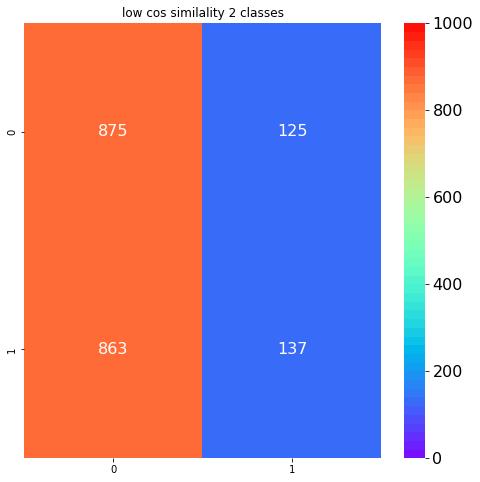

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("low cos similality 2 classes")
plt.rcParams["font.size"] = 16
sns.heatmap(cmatrix, cmap= sns.color_palette('rainbow', 50), annot=True,fmt='.0f',vmin=0,vmax=1000)


In [92]:
from sklearn import metrics

テスト結果を数値で出力する

In [93]:
from sklearn.metrics import classification_report

print("Classification report")
print(classification_report(label_df,pred_df))

Classification report
              precision    recall  f1-score   support

           0       0.50      0.88      0.64      1000
           1       0.52      0.14      0.22      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.43      2000
weighted avg       0.51      0.51      0.43      2000



In [94]:
import pprint
d = metrics.classification_report(label_df,pred_df, output_dict=True)
pprint.pprint(d)

{'0': {'f1-score': 0.6391526661796931,
       'precision': 0.503452243958573,
       'recall': 0.875,
       'support': 1000},
 '1': {'f1-score': 0.21711568938193343,
       'precision': 0.5229007633587787,
       'recall': 0.137,
       'support': 1000},
 'accuracy': 0.506,
 'macro avg': {'f1-score': 0.4281341777808133,
               'precision': 0.5131765036586758,
               'recall': 0.506,
               'support': 2000},
 'weighted avg': {'f1-score': 0.42813417778081325,
                  'precision': 0.5131765036586758,
                  'recall': 0.506,
                  'support': 2000}}


テスト結果を表で出力する

In [95]:
df = pd.DataFrame(d)
df

,0,1,accuracy,macro avg,weighted avg
precision,0.503452,0.522901,0.506,0.513177,0.513177
recall,0.875000,0.137000,0.506,0.506000,0.506000
f1-score,0.639153,0.217116,0.506,0.428134,0.428134
support,1000.000000,1000.000000,0.506,2000.000000,2000.000000


必要に応じてテスト結果を図で出力する

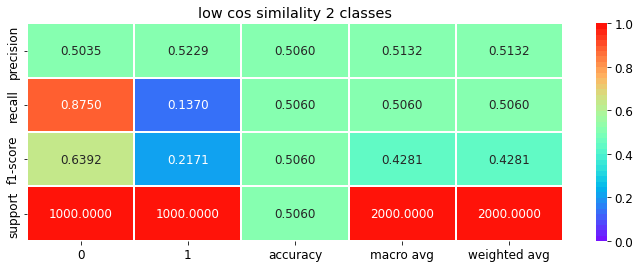

In [96]:
plt.figure(figsize=(12, 4))

plt.rcParams["font.size"] = 12
plt.title("low cos similality 2 classes")
sns.heatmap(df, cmap= sns.color_palette('rainbow', 40), annot=True,fmt='.4f',vmin=0,vmax=1,linewidths=1,linecolor='white')